In [12]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM, LlamaForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

from datasets import load_dataset

import functools
import gc
from collections import defaultdict
from typing import List

import torch
import torch.nn as nn
# from tinychat.models import LlavaLlamaForCausalLM
from transformers.models.bloom.modeling_bloom import BloomForCausalLM
from transformers.models.llama.modeling_llama import LlamaForCausalLM
from transformers.models.opt.modeling_opt import OPTForCausalLM

import numpy as np
from scipy.linalg import eigh

import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

def topk_eigenvectors(A, device):
    A = A.to(device)
    eigenvalues, eigenvectors = torch.linalg.eigh(A)
    eigenvalues = eigenvalues
    eigenvectors = eigenvectors

    # 고유값 행렬 (대각행렬)
    Lambda = torch.diag(eigenvalues)

    # 원래 행렬 복원 검증: A @ V ≈ V @ Lambda
    A_reconstructed = eigenvectors @ Lambda @ eigenvectors.T
    error = torch.norm(A - A_reconstructed)
    
    # assert error < 1e-4, f"Error: {error.item()}"
    print(f"재구성 오차 (||A - VΛV^T||): {error.item()}")
    return eigenvalues.cpu(), eigenvectors.cpu()

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        # layers = [model.model.layers, model.model.vision_tower.vision_tower.vision_model.encoder.layers]
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    else:
        raise NotImplementedError(type(model))
    return layers

In [13]:
def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H

In [14]:
# quip_hess_base_path = '/home/jgryu/Weight_compression/Wparam_dataset/quip_hess'

# model_list = os.listdir(quip_hess_base_path)
# quip_hess_path = [os.path.join(quip_hess_base_path, model_name) for model_name in model_list]

# sigma_reg = 1e-4

quip_hess_path = ['/workspace/Weight_compression/Wparam_dataset/quip_hess/llama3_8b_6144']

##### llama3_8b_6144 #####
## layer0, qkv ##


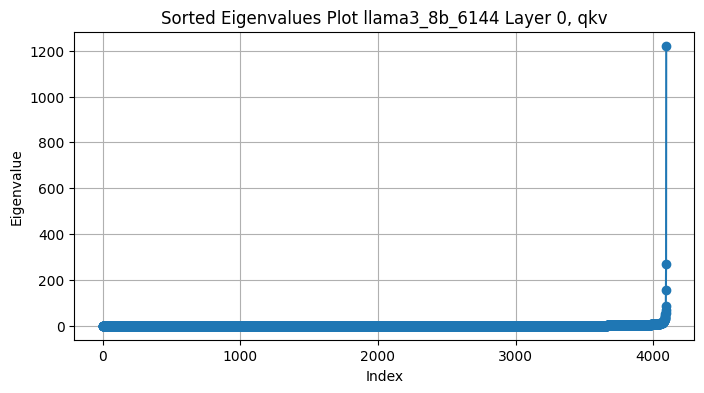

## layer0, o ##


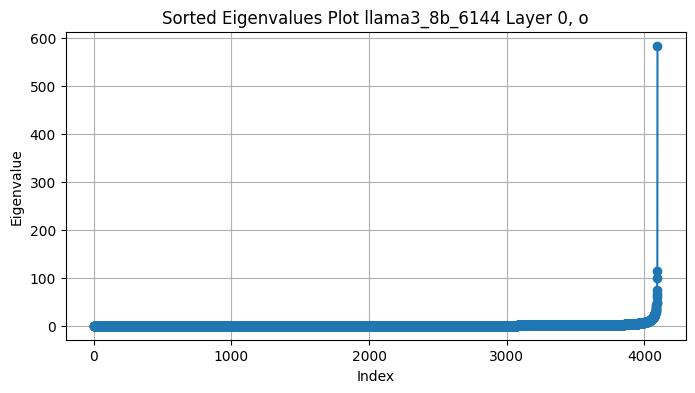

## layer0, up ##


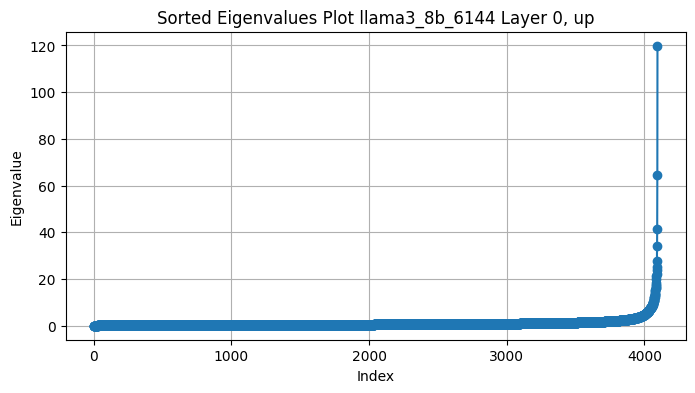

## layer0, down ##


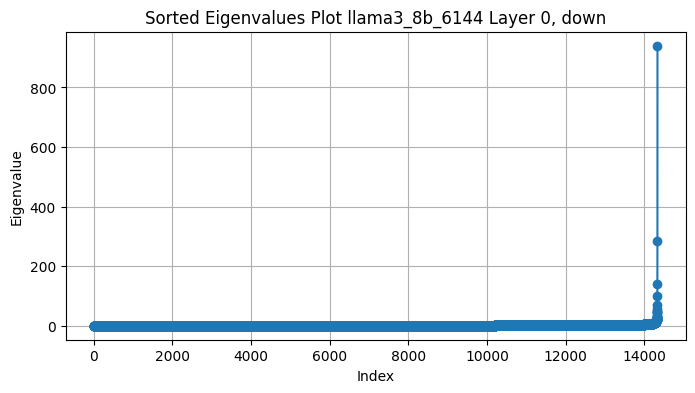

## layer1, qkv ##


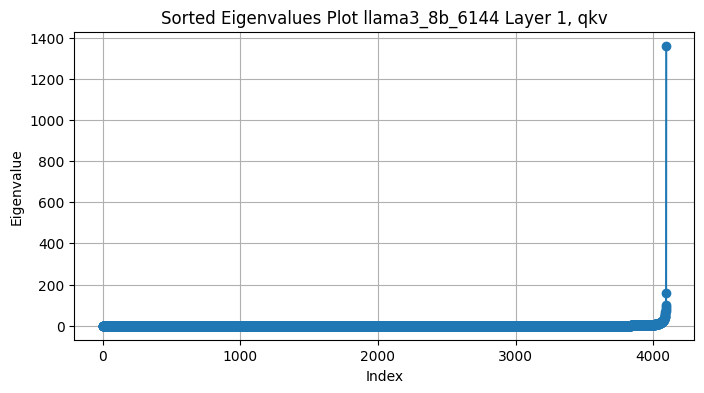

## layer1, o ##


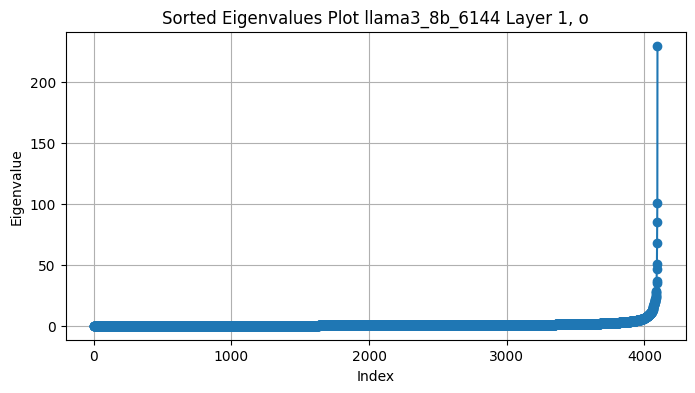

## layer1, up ##


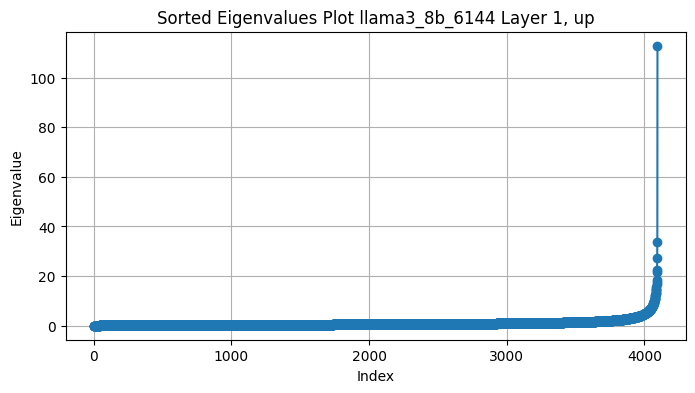

## layer1, down ##


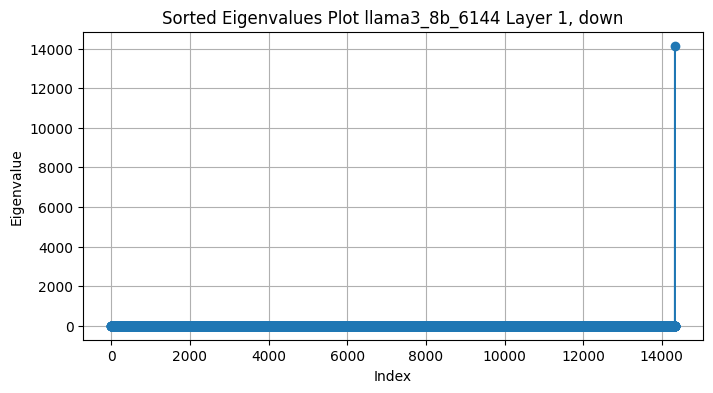

## layer2, qkv ##


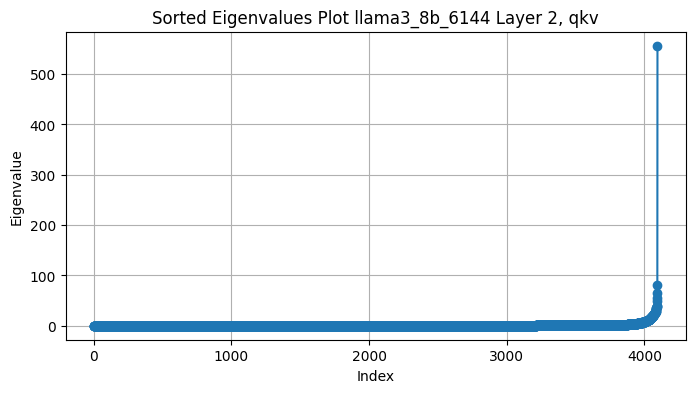

## layer2, o ##


KeyboardInterrupt: 

In [15]:
# plot
sigma_reg = 1e-4
import matplotlib.pyplot as plt
for quip_hess in quip_hess_path:
    save_path = quip_hess.replace('quip_hess', f'quip_hess_eig_reg{sigma_reg}')
    # os.makedirs(save_path, exist_ok=True)
    print(f'##### {quip_hess.split("/")[-1]} #####')
    # for i in tqdm(range(40)):
    for i in [0, 1, 2, 10, 30, 31]:

        for k in ['qkv', 'o', 'up', 'down']:
            print(f'## layer{i}, {k} ##')
            e = torch.load(f'{save_path}/{i}_{k}_eig.pt')
            
            eigenvalues = e['eigenvalues']

            if isinstance(eigenvalues, torch.Tensor):
                eigenvalues_np = eigenvalues.cpu().numpy()
            else:
                eigenvalues_np = eigenvalues

            # 내림차순 정렬
            # sorted_eigenvalues = np.sort(eigenvalues_np)[::-1]
            sorted_eigenvalues = eigenvalues_np

            plt.figure(figsize=(8, 4))
            plt.plot(sorted_eigenvalues, marker='o')
            plt.title('Sorted Eigenvalues Plot {} Layer {}, {}'.format(quip_hess.split("/")[-1], i, k))
            plt.xlabel('Index')
            plt.ylabel('Eigenvalue')
            plt.grid(True)
            plt.show()


In [ ]:
# decomp 하고 저장하기

# for quip_hess in quip_hess_path:
#     save_path = quip_hess.replace('quip_hess', f'quip_hess_eig_reg{sigma_reg}')
#     os.makedirs(save_path, exist_ok=True)
#     print(f'##### {quip_hess.split("/")[-1]} #####')
#     for i in tqdm(range(40)):
#     for i in tqdm(range(40)):
#         try:
#             hess_dict = {}
#             hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
#             hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
#             hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
#             hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
#         except:
#             continue

#         for k, h in hess_dict.items():
#             print(f'## layer{i}, {k} ##')
            
#             H = flat_to_sym(h['flatH'], h['n']).to(device)
#             mu = h['mu'].to(device)
#             H.add_(mu[None, :] * mu[:, None])
#             n_h = h['n']
#             H = regularize_H(H, n_h, sigma_reg)

#             eig = {}
#             s, q = topk_eigenvectors(H, device)
#             eig['eigenvalues'], eig['eigenvectors'] = s, q
#             torch.save(eig, f'{save_path}/{i}_{k}_eig.pt')
#             print(f"{(s[0]/s.sum()).item():.3f}, {(s[-1]/s.sum()).item():.3f}")
#             print(f"{q[-1].max().item():.3f}, {q[-1].min().item():.3f}")



In [ ]:
for quip_hess in quip_hess_path:
    if '2-7b' not in quip_hess: continue
    save_path = quip_hess.replace('quip_hess', f'quip_hess_eig_reg{sigma_reg}')
    # os.makedirs(save_path, exist_ok=True)
    print(f'##### {quip_hess.split("/")[-1]} #####')
    for i in tqdm(range(40)):
        try:
            hess_dict = {}
            hess_dict['qkv'] = torch.load(f'{save_path}/{i}_qkv_eig.pt', weights_only=False)
            hess_dict['o'] = torch.load(f'{save_path}/{i}_o_eig.pt', weights_only=False)
            hess_dict['up'] = torch.load(f'{save_path}/{i}_up_eig.pt', weights_only=False)
            hess_dict['down'] = torch.load(f'{save_path}/{i}_down_eig.pt', weights_only=False)
        except:
            continue

        for k, h in hess_dict.items():
            print(f'## layer{i}, {k} ##')
            s, q = h['eigenvalues'], h['eigenvectors']
            # print(f"{(s[0]/s.sum()).item():.3f}, {(s[-1]/s.sum()).item():.3f}")
            
            sorted_s = torch.sort(s, descending=True).values  # 내림차순 정렬
            cumsum_s = torch.cumsum(sorted_s, dim=0)  # 누적 합
            
            total_sum = sorted_s.sum()
            k = int(0.025 * len(s))
            topk_sum = sorted_s[:k].sum()
            percentage = (topk_sum / total_sum) * 100
            
            print(f"상위 10개의 고유값이 차지하는 비율: {percentage:.2f}%")
            
            # threshold = 0.5 * sorted_s.sum()  # 전체 합의 90%

            # count = torch.searchsorted(cumsum_s, threshold, right=True).item() + 1  # 개수 찾기
            # print(f"90%를 차지하는 eigenvalue 개수: {count}/{len(s)}")



In [ ]:
import torch
d  = torch.load('/workspace/Weight_compression/Wparam_dataset/quip_hess_eig_reg0.0001/llama3_8b_6144/0_down_eig.pt')

In [ ]:
d['eigenvalues'].shape
d['eigenvectors'].shape

In [ ]:
import torch

# 값의 편차가 큰 대칭 행렬 생성
A = torch.tensor([[1000.0, 2.0, 3.0], 
                  [2.0, 0.01, 4.0], 
                  [3.0, 4.0, 0.0001]])

# LDL 분해 수행
L, D, _ = torch.linalg.ldl(A)

print("L 행렬:\n", L)
print("D 행렬:\n", D)


In [ ]:
import numpy as np
import scipy.linalg

# 값의 편차가 큰 대칭 행렬 생성
A = np.array([[1000.0, 2.0, 3.0], 
              [2.0, 0.01, 4.0], 
              [3.0, 4.0, 0.0001]])

# LDL 분해 수행
L, D, perm = scipy.linalg.ldl(A, lower=True)

# 결과 출력
print("L 행렬:\n", L)
print("D 행렬:\n", D)


In [ ]:
import torch

def ldl_decomposition(A):
    # Cholesky 분해 수행 (A = L L^T)
    L_cholesky = torch.linalg.cholesky(A)

    # D 행렬: Cholesky 분해에서 얻은 L의 대각 원소의 제곱
    D = torch.diag(torch.diag(L_cholesky)**2)

    # L 행렬: Cholesky 행렬을 정규화하여 얻음
    L = L_cholesky / torch.diag(L_cholesky).reshape(-1, 1)

    return L, D

# 대칭 행렬 (값의 편차가 큰 경우)
A = torch.tensor([[1.0, 2.0, 3.0], 
                  [2.0, 1000, 4.0], 
                  [3.0, 4.0, 0.0001]])

# LDL 분해 수행
L, D = ldl_decomposition(A@A.T)

# 결과 출력
print("L 행렬:\n", L)
print("D 행렬:\n", D)
